# Natural language processing pipeline : use plot data to extract meaningfull insights

**Pipeline:**

1) Extract tags for each movie genres
2) Natural language text generation of new plots based on key tags
3) Sentiment analysis of plots

# Part I : Extract tags for each movie genres

This code aims to: 

- Clean the movies plots
- Extract the key tags for each genre
- We try 4 methodologies
- Vizualize main themes

In [3]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Open data

In [4]:
df_movie = pd.read_csv('../Datasets/movies_cleaned_dataset.csv')
df_movie.head()

,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,averageRating,numVotes,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name
0,Ghosts of Mars,14010832,98.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","['Thriller', 'Science Fiction', 'Horror', 'Adv...",English Language,Drama,United States of America,USA,"Set in the second half of the 22nd century, th...",...,4.9,56894.0,28000000,tt0228333,0,0,-13989168,-1.870336e+07,nm0000118,John Carpenter
1,White Of The Eye,0,110.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","['Thriller', 'Erotic thriller', 'Psychological...",English Language,Drama,United Kingdom,Europe,A series of murders of rich young women throug...,...,6.1,2894.0,0,tt0094320,0,0,0,0.000000e+00,nm0131910,Donald Cammell
2,A Woman in Flames,0,106.0,"{""/m/07s9rl0"": ""Drama""}",Drama,German Language,Other,Germany,Europe,"Eva, an upper class housewife, becomes frustra...",...,5.9,623.0,0,tt0083949,0,0,0,0.000000e+00,nm0885554,Robert van Ackeren
3,The Sorcerer's Apprentice,0,86.0,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","['Family Film', 'Fantasy', 'Adventure', 'World...",English Language,Family,South Africa,Africa,"Every hundred years, the evil Morgana returns...",...,NaN,NaN,0,NaN,0,0,0,0.000000e+00,NaN,Unknown
4,Little city,0,93.0,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","['Romantic comedy', 'Ensemble Film', 'Comedy-d...",English Language,Drama,United States of America,USA,"Adam, a San Francisco-based artist who works a...",...,5.8,1129.0,0,tt0119548,0,0,0,0.000000e+00,nm0070142,Roberto Benabib


In [3]:
df_movie.Top_genres.replace('Action/Adventure', 'Action_Adventure', inplace=True)

In [4]:
df_movie.Top_genres.unique()

array(['Drama', 'Other', 'Family', 'Fiction', 'Action_Adventure',
       'Horror'], dtype=object)

## First approach: extracting Stopwords

- We observe that extracting punctuation and stopwords, and identify the most common remaining words does not allow us to get truly meaning full list of words for each genre. 
- We ought to explore another methodology to extract meaningfull lexicas.

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Function to preprocess and tokenize text
def preprocess_text(text):
    """ 
    This function takes in a text and returns a list of tokens after removing stopwords
    """
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Function to identify words defining a genre
def identify_genre_words(df, genre, num_words=30):
    """
    This function takes in a dataframe and a genre and returns the most common words in the genre's movie plots. 
    """
    genre_df = df[df['Top_genres'] == genre]
    all_tokens = [token for plot in genre_df['Plot_summary'] for token in preprocess_text(plot)]
    word_counts = Counter(all_tokens)
    
    # Get the most common words
    common_words = [word for word, count in word_counts.most_common(num_words)]
    return common_words

# Example usage:
for genre in df_movie['Top_genres'].unique():
    genre_words = identify_genre_words(df_movie, genre, num_words=30)
    print(f"Words defining {genre}: {', '.join(genre_words)}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinedebouille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antoinedebouille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Words defining Drama: one, father, back, two, tells, film, man, life, home, new, mother, family, later, time, love, police, house, finds, also, find, however, get, wife, goes, young, day, takes, go, away, son
Words defining Other: one, film, back, father, two, love, man, life, time, get, family, also, house, tom, home, however, tells, new, gets, mother, goes, takes, finds, find, story, young, later, away, go, day
Words defining Family: one, back, get, love, father, new, two, tells, family, home, film, time, however, go, find, also, mother, day, house, life, finds, gets, help, man, goes, friends, first, takes, later, school
Words defining Fiction: one, back, earth, two, time, find, however, ship, new, planet, also, world, film, alien, escape, finds, later, man, help, takes, home, killed, first, tells, group, get, life, city, space, begins
Words defining Action/Adventure: one, back, two, men, father, man, killed, film, also, tells, get, police, however, later, find, fight, time, new, tak

## Second approach: Extracting tags using SpaCy

### Named entity recognition
https://spacy.io/usage/linguistic-features

We use spacy pre-trained model to identify the tags for each movies. This library allows to identify entity types for each word and therefore to extract only thoses who are truly meaningfull. 

**The entity types are:**

- PERSON: People, including fictional.
- ORG: Organizations, e.g., companies, governments, institutions.
- GPE: Geopolitical entities, e.g., countries, cities, states.
- LOC: Locations, e.g., non-GPE locations, mountain ranges, bodies of water.
- EVENT: Named events, e.g., hurricanes, wars, sports events.
- DATE: Absolute or relative dates or periods.
- TIME: Times smaller than a day.
- MONEY: Monetary values, including unit.
- QUANTITY: Measurements, as of weight or distance.
- PERCENT: Percentage, including "%" symbol.
- CARDINAL: Numerals that do not fall under another type.
- ORDINAL: "first", "second", etc.
- PRODUCT: Objects, vehicles, foods, etc. (not services).
- WORK_OF_ART: Titles of books, songs, etc.
- LANGUAGE: Any named language.
- LAW: Named documents made into laws.
- NORP: Nationalities or religious or political groups.

### Adding nouns and proper nouns
We also add position "nouns" and "proper nouns" to catch relevant keywords

**Code description:**

- This code uses spaCy to extract relevant tags and concepts from movie plot summaries. 
- It identifies entities like locations, geopolitical entities, events, nationalities, and organizations, as well as concepts like nouns and proper nouns. 
- The resulting list represents key elements in the text data, aiding in tasks such as genre classification and thematic analysis.


#### Testing the Scipy packages on the first plot summaries

In [7]:
import spacy
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

# Function to extract tags from a plot summary
def extract_relevant_tags_and_concepts(plot_summary):
    """
     Extracts relevant tags and concepts from a plot summary using spaCy
    """
    doc = nlp(plot_summary)
    relevant_tags_and_concepts = [ent.text for ent in doc.ents if ent.label_ in ["LOC", "GPE", "EVENT", "NORP", "ORG"]]  # Adjust entity types as needed
    concepts = [token.text for token in doc if token.pos_ in ["NOUN", "PROPN"]]  # Include additional POS tags for concepts: proper noun and nouns
    relevant_tags_and_concepts.extend(concepts)

    # Remove common words from a stopword list
    relevant_tags_and_concepts = [token for token in relevant_tags_and_concepts if token not in STOPWORDS]

    # apply lemmatization
    lemmatizer = WordNetLemmatizer()
    relevant_tags_and_concepts = [lemmatizer.lemmatize(tag) for tag in relevant_tags_and_concepts]

    # apply lower case
    relevant_tags_and_concepts = [tag.lower() for tag in relevant_tags_and_concepts]

    # remove duplicates
    relevant_tags_and_concepts = list(set(relevant_tags_and_concepts))  
    return relevant_tags_and_concepts

# testing the function
test_plots = df_movie['Plot_summary'].head(3).values
for plot in test_plots:
    print("plot:", plot)
    print("tags:",extract_relevant_tags_and_concepts(plot),"\n")

plot: Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a police officer, Melanie Ballard , second in command of a small team alongside Sergeant Jericho  sent to pick up and transport a prisoner named Desolation Williams . Arriving at the remote mining town where Williams is being held, Ballard finds virtually all of the people missing. She learns that the miners had discovered an underground doorway created by an ancient Martian civilization. When the door was opened it released "ghosts," disembodied spirits which possessed the miners. Violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. With their team leader Helena Bradock  murdered, Ballard must fight off the attacking miners, esc

#### For each genre, we idendity the most common relevant tags and concepts

In [48]:
tags = {}
# for all main genres : 
for genre in df_movie['Top_genres'].unique():
    number_movies = df_movie[df_movie['Top_genres'] == genre].shape[0]

    # Extract tags and concepts from the top 100 movies of each genre
    genre_df = df_movie[df_movie['Top_genres'] == genre].sort_values(by='averageRating', ascending=False) # Sort by rating
    print(f"Number of movies in {genre}: {len(genre_df)}")
    selected_plots = genre_df['Plot_summary'].head(100).values 
    all_tags_and_concepts = [extract_relevant_tags_and_concepts(plot) for plot in selected_plots]

    # Flatten list of lists
    all_tags_and_concepts = [tag for tags in all_tags_and_concepts for tag in tags] 

    # Count the number of occurrences of each tag
    tag_counts = Counter(all_tags_and_concepts)
    tags[genre] = tag_counts
    print(f"Most common tags and concepts for {genre}: {tag_counts.most_common(10)}\n")

# Create a DataFrame from the tags dictionary
tags_df = pd.DataFrame.from_dict(tags, orient='index').fillna(0).astype(int).T
tags_df["total"] = tags_df.sum(axis=1)
tags_df = tags_df.sort_values(by='total', ascending=False)

tags_df

Number of movies in Drama: 16115
Most common tags and concepts for Drama: [('life', 55), ('day', 51), ('time', 49), ('year', 47), ('film', 43), ('man', 42), ('father', 38), ('death', 38), ('love', 36), ('friend', 36)]

Number of movies in Other: 13334
Most common tags and concepts for Other: [('film', 45), ('story', 32), ('life', 29), ('day', 27), ('father', 26), ('time', 26), ('love', 25), ('son', 24), ('year', 22), ('family', 21)]

Number of movies in Family: 6265
Most common tags and concepts for Family: [('father', 52), ('love', 52), ('time', 50), ('friend', 49), ('day', 46), ('life', 45), ('man', 39), ('film', 38), ('family', 36), ('year', 35)]

Number of movies in Fiction: 1343
Most common tags and concepts for Fiction: [('time', 54), ('life', 42), ('year', 41), ('friend', 39), ('death', 39), ('day', 38), ('world', 38), ('film', 37), ('earth', 37), ('way', 35)]

Number of movies in Action_Adventure: 3544
Most common tags and concepts for Action_Adventure: [('life', 46), ('man', 4

,Drama,Other,Family,Fiction,Action_Adventure,Horror,total
time,49,26,50,54,44,39,262
life,55,29,45,42,46,31,248
film,43,45,38,37,40,39,242
day,51,27,46,38,37,38,237
friend,36,19,49,39,36,35,214
...,...,...,...,...,...,...,...
can,0,0,1,0,0,0,1
sekhar,0,0,1,0,0,0,1
blurts,0,0,1,0,0,0,1
new year’s eve,0,0,1,0,0,0,1


In [32]:
# saving dataframe
tags_df.to_csv('../Datasets/tags_per_genre.csv', index_label='Genre')

## Third approach: using Empath to improve the tags extractions

We try using the Empath package to extract tags

https://github.com/Ejhfast/empath-client


In [44]:
from empath import Empath
from collections import Counter

# Initialize Empath
lexicon = Empath()

tags_empath = {}

for genre in df_movie['Top_genres'].unique():
    genre_df = df_movie[df_movie['Top_genres'] == genre].sort_values(by='averageRating', ascending=False)
    print(f"Number of movies in {genre}: {len(genre_df)}")
    
    selected_plots = genre_df['Plot_summary'].head(100).values
    all_tags_and_concepts = []

    # Use Empath to extract tags and concepts
    for plot in selected_plots:
        empath_tags = lexicon.analyze(plot, normalize=True)
        for tag, score in empath_tags.items():
            if score > 0.01:  # Adjust the threshold as needed
                all_tags_and_concepts.append(tag)
    # apply lemmatization
    lemmatizer = WordNetLemmatizer()
    all_tags_and_concepts = [lemmatizer.lemmatize(tag) for tag in all_tags_and_concepts]

    # Count the occurrences of each tag
    tag_counts = Counter(all_tags_and_concepts)
    tags_empath[genre] = tag_counts

    print(f"Most common tags and concepts for {genre}: {tag_counts.most_common(10)}\n")

# Create a DataFrame from the tags dictionary
tags_df_2 = pd.DataFrame.from_dict(tags_empath, orient='index').fillna(0).astype(int).T
tags_df_2["total"] = tags_df_2.sum(axis=1)
tags_df_2 = tags_df_2.sort_values(by='total', ascending=False)

# Save the DataFrame to a CSV file
tags_df_2.to_csv('../Datasets/tags_per_genre_empath.csv', index_label='Genre')
tags_df_2

Number of movies in Drama: 16115
Most common tags and concepts for Drama: [('family', 31), ('child', 30), ('negative_emotion', 29), ('crime', 25), ('death', 22), ('home', 22), ('wedding', 20), ('war', 19), ('leader', 14), ('positive_emotion', 14)]

Number of movies in Other: 13334
Most common tags and concepts for Other: [('child', 50), ('family', 46), ('wedding', 30), ('friend', 30), ('positive_emotion', 27), ('fun', 26), ('home', 26), ('youth', 24), ('death', 23), ('negative_emotion', 22)]

Number of movies in Family: 6265
Most common tags and concepts for Family: [('family', 53), ('child', 46), ('wedding', 27), ('home', 27), ('positive_emotion', 26), ('friend', 26), ('negative_emotion', 22), ('death', 21), ('party', 20), ('celebration', 14)]

Number of movies in Fiction: 1343
Most common tags and concepts for Fiction: [('negative_emotion', 21), ('war', 20), ('child', 17), ('leader', 16), ('family', 16), ('fight', 14), ('ship', 12), ('death', 12), ('kill', 12), ('science', 11)]

Numb

,Drama,Other,Family,Fiction,Action_Adventure,Horror,total
child,30,50,46,17,33,35,211
family,31,46,53,16,32,29,207
negative_emotion,29,22,22,21,38,43,175
death,22,23,21,12,26,38,142
home,22,26,27,10,14,28,127
...,...,...,...,...,...,...,...
exasperation,0,1,0,0,0,0,1
ugliness,0,1,0,0,0,0,1
fabric,0,1,0,0,0,0,1
surprise,0,1,0,0,0,0,1


## Fourth approch: LDA multicore methodology

- We try using exactly the same topic detection pipeline than in exercise session 9.

- We only keep the 200 most relevant tags for each genre.

- We observe that we have less tags that are present in all categories.

In [43]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tags_to_keep = 200

nlp = spacy.load("en_core_web_sm")

tags_3 = {}
tags_4 = {}

# For each genre, extract the top 100 movies and plot summaries
for genre in df_movie['Top_genres'].unique(): # for each genre
    genre_df = df_movie[df_movie['Top_genres'] == genre].sort_values(by='averageRating', ascending=False) # Sort by rating
    print(f"Number of movies in {genre}: {len(genre_df)}")
    
    selected_plots = genre_df['Plot_summary'].head(100).values # Select the top 100 movies
    
    processed_docs = list()
    for plot in selected_plots:
        # Process document using Spacy NLP pipeline.
        doc = nlp(plot)
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list
        doc = [token for token in doc if token not in STOPWORDS]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)
    docs = processed_docs
    del processed_docs

    bigram = Phrases(docs, min_count=15) # Add bigrams

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)


    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 5
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    # models
    params = {'passes': 10, 'random_state': seed}
    base_models = dict()
    model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                    passes=params['passes'], random_state=params['random_state'])
    
    print(model.show_topic(1,20))

    # Get the top 30 words to a list
    tags_3[genre] = model.show_topic(1,tags_to_keep)
    
    top_words = [word for word, _ in model.show_topic(1, tags_to_keep)]
    tags_4[genre] = top_words

Number of movies in Drama: 16115
[('love', 0.009254228), ('village', 0.0082480535), ('son', 0.008216627), ('house', 0.007584213), ('prison', 0.0074274046), ('try', 0.007022221), ('year', 0.0066024438), ('friend', 0.006557158), ('daughter', 0.006458488), ('follow', 0.0059476406), ('machine', 0.005876049), ('live', 0.005845993), ('day', 0.005769212), ('later', 0.005617973), ('story', 0.005568004), ('family', 0.005566137), ('die', 0.00554651), ('visit', 0.0054956377), ('film', 0.0054817535), ('lose', 0.005478989)]
Number of movies in Other: 13334
[('film', 0.096167415), ('New', 0.026228521), ('life', 0.02205889), ('people', 0.020149648), ('follow', 0.0180694), ('war', 0.017851692), ('footage', 0.016669001), ('character', 0.015159718), ('include', 0.014118246), ('year', 0.014071546), ('travel', 0.01392626), ('experience', 0.013426383), ('group', 0.012694454), ('course', 0.011547491), ('War', 0.011077422), ('appear', 0.0110302465), ('world', 0.010827626), ('story', 0.0101471795), ('find', 0

In [31]:
tags_4_df = pd.DataFrame.from_dict(tags_4, orient='index').fillna(0).T
tags_4_df.to_csv('../Datasets/tags_per_genre_lda.csv', index_label='Genre')
tags_4_df

,Drama,Other,Family,Fiction,Action_Adventure,Horror
0,love,film,return,creature,attack,child
1,son,New,man,Earth,army,zombie
2,village,life,reveal,ship,police,vampire
3,house,people,home,alien,plan,tell
4,try,follow,discover,film,lead,island
5,prison,war,castle,crew,son,family
6,year,footage,away,kill,force,man
7,friend,character,escape,planet,death,priest
8,daughter,include,order,end,battle,later
9,machine,year,tell,space,help,meet


## Cleaning tags and vizualization

- We observe that most categories have the same best tags at first : ‘‘time‘‘, "film", "life", "man" "father",...
- These tags don't seem very specific to a given genre.
- We are exploring methodologies to extract only the meaningfull tags for each genre

<Axes: >

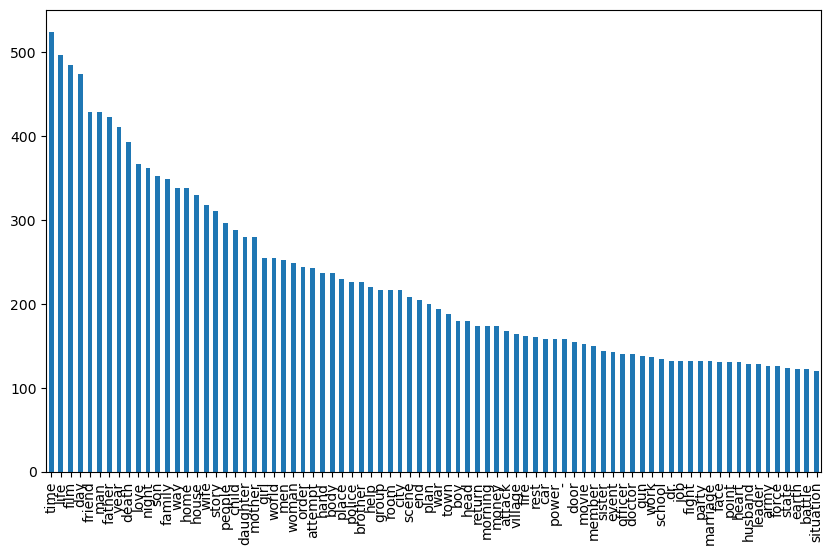

In [58]:
# keep only tags that are in more than two genres
tags_df = tags_df[tags_df.sum(axis=1) > 1]
tags_df

# delete index when their is no 0 on the row
tags_df = tags_df[(tags_df.T != 0).any()]
tags_df['total'] = tags_df.sum(axis=1)
tags_df.sort_values(by='total', ascending=False).head(10)

# Plot the most common tags
fig, ax = plt.subplots(figsize=(10, 6))
tags_df.sort_values(by='total', ascending=False)['total'].head(80).plot(kind='bar', ax=ax)

### Try taking intersection of the 3 methods to take only the relevant tags for each genre

- We observe that the intersection between all 3 methods are very small sets.
- It shows that these methodologies are very different.
- We need to evaluate the methods based on a metric, to find the best ones.


In [57]:
tags_intersection = dict()

for genre in df_movie['Top_genres'].unique():
    
    tags_lda = tags_4_df[genre].values.tolist()
    tags_empath_2 = tags_empath[genre].most_common(1000)
    tags_empath_2 = [tag for tag, _ in tags_empath_2]
    tags_spacy = tags_df[genre].sort_values(ascending=False).index.tolist()[:10000]

    # Taking intersection of tags from all three methods
    tags = list(set(tags_lda) & set(tags_empath_2) & set(tags_spacy))
    tags_intersection[genre] = tags

    print(f"Number of tags in {genre}: {len(tags)}")    

# Create a DataFrame from the tags dictionary
tags_intersection_df = pd.DataFrame.from_dict(tags_intersection, orient='index').fillna(0).T
tags_intersection_df

Number of tags in Drama: 5
Number of tags in Other: 4
Number of tags in Family: 7
Number of tags in Fiction: 3
Number of tags in Action_Adventure: 4
Number of tags in Horror: 2


,Drama,Other,Family,Fiction,Action_Adventure,Horror
0,prison,war,order,home,help,family
1,family,work,help,power,love,child
2,love,family,fight,ship,death,0
3,friend,music,child,0,war,0
4,death,0,home,0,0,0
5,0,0,money,0,0,0
6,0,0,friend,0,0,0


#### Creating Wordclouds for each genre

In [41]:
# Using LDA to extract tags and concepts

output_directory = "../Graph pictures/wordclouds/lda/"

for genre in df_movie['Top_genres'].unique():
    tag_counts = tags_3[genre]
    # Create a word cloud
    try:
        wordcloud_dict = {word: weight for word, weight in tag_counts}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

        # Plot the WordCloud image
        plt.figure(figsize=(8, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Tags and Concepts in {genre}")
        figure_filename = f"{output_directory}{genre}_wordcloud.png"
        plt.savefig(figure_filename, bbox_inches='tight')
        plt.close()
        #plt.show()
        
    except Exception as e:
        print(f"Error for {genre}. Error: {e}")

In [40]:
# Using SpaCy to extract tags and concepts

output_directory = "../Graph pictures/wordclouds/SpaCy/"

for genre in df_movie['Top_genres'].unique():
    tag_counts = tags[genre]
    # Create a word cloud
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)
        # Plot the WordCloud image
        plt.figure(figsize=(6, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Tags and Concepts in {genre}")
        figure_filename = f"{output_directory}{genre}_wordcloud.png"
        plt.savefig(figure_filename, bbox_inches='tight')
        plt.close()
        #plt.show()
        
    except Exception as e:
        print(f"No tags for {genre}. Error: {e}")

In [45]:
# Using empath to extract tags and concepts

output_directory = "../Graph pictures/wordclouds/empath/"

for genre in df_movie['Top_genres'].unique():
    tag_counts = tags_empath[genre]
    # Create a word cloud
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)
        # Plot the WordCloud image
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Tags and Concepts in {genre}")
        figure_filename = f"{output_directory}{genre}_wordcloud.png"
        plt.savefig(figure_filename, bbox_inches='tight')
        plt.close()
        #plt.show()
        
    except Exception as e:
        print(f"No tags for {genre}. Error: {e}")

## Conclusions on Part I

| Method | Positive | Negative |
|----------|----------|----------|
|Stopwords only|-|Not relevant methodology to extract themes|
|SpaCy|Allows to extract entities and nouns  |Many common words to all genres |
|Empath|analyzes text across lexical categories and generates new lexical categories. Small number of relevant keywords|Many common words to all genres |
|LDA|Adds a significance value for each tag |Many common words to all genres  |

It is difficult to introduce a metric to evaluate all three methods. 
We have therefore plot the worclouds for each method and chose to keep **Empath** Method, which gave the most "plausible" keywords, based on the genre of the movies. We should however note that this is only based on our judgement, which is subjective. 

**Example of analysis for family movies**

Family films are centered on heartwarming stories that emphasize familial relationships. Plots center on the joys and tribulations of family life, with a particular emphasis on children. Weddings, homes, and happy feelings are among the themes used to create an upbeat mood. Friendship, celebrations, and optimism are important themes, while musical components offer entertainment value. These films strike a balance between relatable experiences like school and youth with positive values like helping, giving, and leadership. Despite occasional setbacks, Family films promote unity and the continuing strength of familial bonds, providing wholesome and entertaining experiences for people of all ages.

# Part II: Natural language text generation of new plots based on key tags

- Using openAI API, we try to generate new movie plots for each genre, based on the selection of tags for each genre.

- This part only aims to show that we could use Large language models to generate new ideas of movies.

In [65]:
import os
from openai import OpenAI

client = OpenAI()

# Function to generate movie plot summaries
def generate_movie_summary(tags):
    # Concatenate tags to form a prompt for the model
    prompt = f"Generate a movie plot summary based on the tags: {', '.join(tags)}"

    response = client.completions.create(
    model="gpt-3.5-turbo-instruct",
    max_tokens=200,
    prompt=prompt

    )
    summary = response.choices[0].text
    return summary
# Example: Generate a summary for a specific genre

def genre_summaries():
    plots = {}
    for genre in df_movie['Top_genres'].unique():
        tags_to_generate = tags_df_2[genre].sort_values(ascending=False).index.tolist()[:10]
        generated_summary = generate_movie_summary(tags_to_generate)
        # Print the generated summary
        print(f"Generated Summary for {genre}:{generated_summary}\n")
        plots[genre] = generated_summary

    # Create a DataFrame from the plots dictionary
    plots_df = pd.DataFrame.from_dict(plots, orient='index', columns=['Plot_summary'])
    plots_df.index.name = 'Genre'
    plots_df.to_csv('../Datasets/generated_plots.csv')
    return plots_df

#genre_summaries()

Generated Summary for Drama:


In a small town, a close-knit family struggles to keep their home together amidst the negative emotions caused by the mother's untimely death. The youngest child, a precocious and sensitive boy, seeks solace in the outdoors and occasionally acts out in frustration.

As the family grieves, the town is rocked by a series of suspicious crimes, casting a dark cloud over the once peaceful community. When the town's beloved school teacher is found murdered, tensions rise and suspicions fall on a troubled teenager who has been in and out of the juvenile justice system.

Meanwhile, the oldest daughter prepares to marry her high school sweetheart, bringing the family together for a joyous occasion. But as the wedding day approaches, the secrets of the town start to unravel and the family is forced to confront the painful truth that their late mother may have been involved in the crimes.

As the town becomes consumed by fear and anger, the family must band together

# Part III: Sentiment analysis of plots

We want to add a sentiment score to all plots and try to find significant relationship between the genres dans the scores.

In [106]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# avoid multiple calculations
from cache_to_disk import cache_to_disk

In [107]:
# We take a sample of 1000 movies

df_movie_2 = df_movie[df_movie['Top_genres'] != "Other"] # we remove the "Other" genre

df_sentiment = df_movie_2[['Movie_name', 'Plot_summary', 'Top_genres','averageRating']].copy().sample(1000, random_state=42)
df_sentiment.head()

,Movie_name,Plot_summary,Top_genres,averageRating
31489,Raja Aur Runk,Raja Aur Runk is the story of a prince and a p...,Family,6.8
32152,The Black Corsair,"Emilio di Roccanera, The Black Corsair, seeks ...",Action_Adventure,6.3
14678,Spies Like Us,"Austin Millbarge is a geekish, basement-dwelli...",Action_Adventure,6.4
11455,Vacation with Derek,Casey and Derek are back and continue their si...,Family,NaN
26614,Live Free or Die Hard,The Federal Bureau of Investigation responds ...,Drama,7.1


In [108]:
@cache_to_disk(1)
def apply_sentiment_scoring(df_sentiment):
    analyzer = SentimentIntensityAnalyzer()
    df_sentiment['neg'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
    df_sentiment['neu'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
    df_sentiment['pos'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
    df_sentiment['compound'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    return df_sentiment

df_sentiment = apply_sentiment_scoring(df_sentiment)

In [109]:
df_sentiment

,Movie_name,Plot_summary,Top_genres,averageRating,neg,neu,pos,compound
31489,Raja Aur Runk,Raja Aur Runk is the story of a prince and a p...,Family,6.8,0.079,0.871,0.050,-0.7958
32152,The Black Corsair,"Emilio di Roccanera, The Black Corsair, seeks ...",Action_Adventure,6.3,0.336,0.664,0.000,-0.8442
14678,Spies Like Us,"Austin Millbarge is a geekish, basement-dwelli...",Action_Adventure,6.4,0.081,0.835,0.084,-0.4404
11455,Vacation with Derek,Casey and Derek are back and continue their si...,Family,NaN,0.073,0.776,0.151,0.9192
26614,Live Free or Die Hard,The Federal Bureau of Investigation responds ...,Drama,7.1,0.141,0.793,0.066,-0.9970
...,...,...,...,...,...,...,...,...
19192,The End of Innocence,A young girl is spiritually torn apart by forc...,Drama,5.2,0.159,0.771,0.070,-0.4588
19693,Romance on the High Seas,Elvira Kent and her husband Michael suspect ...,Family,7.0,0.067,0.783,0.150,0.9796
750,Larceny on the Air,Dr. Lawrence Baxter runs a medical-themed radi...,Drama,5.3,0.113,0.787,0.100,-0.1779
2108,Night Editor,"Crane Stewart , the editor of the New York Sta...",Drama,6.7,0.144,0.788,0.068,-0.8948


<Axes: xlabel='neg', ylabel='pos'>

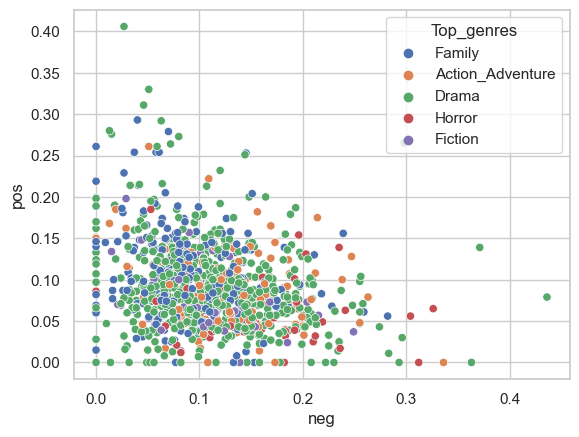

In [94]:
# plot on a graph

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# plot neg vs pos
sns.scatterplot(data=df_sentiment, x="neg", y="pos", hue="Top_genres")

<Axes: xlabel='neg', ylabel='pos'>

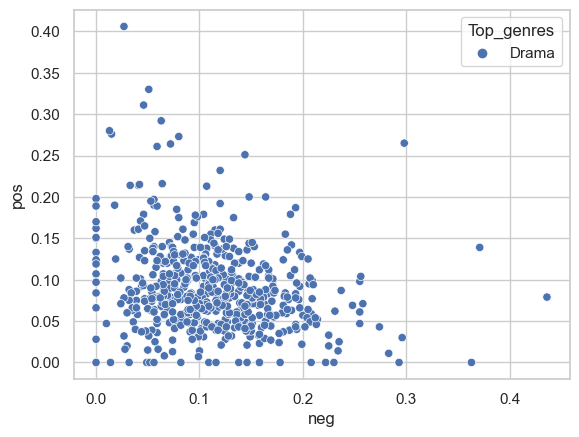

In [114]:
sns.scatterplot(data=df_sentiment[df_sentiment["Top_genres"]=="Drama"], x="neg", y="pos", hue="Top_genres")

<Axes: xlabel='compound', ylabel='averageRating'>

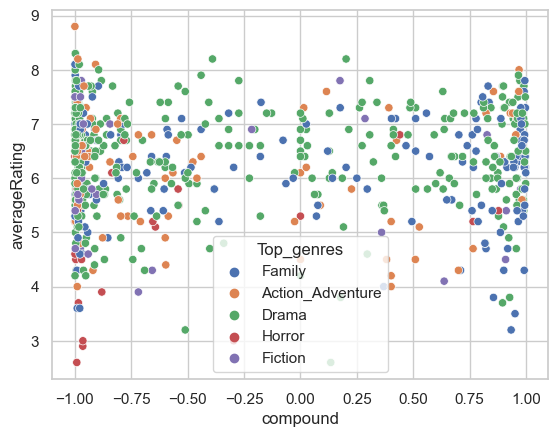

In [95]:
# plot compound vs averageRating
sns.scatterplot(data=df_sentiment, x="compound", y="averageRating", hue="Top_genres")

## Conclusions on Part III:

- The plots don't seem to convey any relevant relationship between score and genres.

In [77]:
df_sentiment.to_csv('../Datasets/sentiment_scores.csv', index=False)